In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
from urllib.request import Request, urlopen
from IPython.display import Markdown as md
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.model_selection import cross_validate, RepeatedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, quantile_transform
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV, RidgeCV
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, r2_score
from sklearn.compose import make_column_transformer
from xgboost import XGBClassifier, plot_importance

%matplotlib inline

# Prognosis of COVID-19 cases in Alberta

The purpose fo this notebook is to study COVID cases admisted to hospitals in Alberta, and assess the prognosis of complications complications, death, and days to death.

1. Data set.
2. Data analysis: correlations.
3. Prognosis of complications.
4. Prognosis of death.
5. Prognosis of the length of stay.

## 1. Data set

The data set consist of 5881 entries of Alberta patients admited into hospitals. Variables include age, sex, comorbidities (separate), date of COVID test, symptoms (separate), length of stay, and days to admission/discharge/death.

**Features**
- **Input**:
  - Categorical: age group, sex, date, comorbidities, symptoms, ICU, ventilation
  - Numerical: age, number of comorbidities/symptoms, days to admission.
- **Output**: ICU, ventilation, death, days to death.
- **Other**: days to discharge

In [2]:
df = pd.read_csv('../../data/AHS/Restricted/analysis.csv', 
                 true_values=["Yes"], parse_dates=[3], index_col=0)
df['PHN_ENC'] = df['PHN_ENC'].astype('category')
df['Sex'] = df['Sex'].astype('category')
df['Sex (codes)'] = df['Sex'].cat.codes
df['ICU or ventilation'] = df['ICU'] | df['Ventilation']
cat = pd.api.types.CategoricalDtype(categories=['Under 1 year', '1-4 years', '5-9 years',
                                                '10-19 years', '20-29 years', '30-39 years',
                                                '40-49 years', '50-59 years', '60-69 years',
                                                '70-79 years', '80+ years'], ordered=True)
df['Age group'] = df['Age group'].astype(cat)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5881 entries, 0 to 5882
Data columns (total 68 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   PHN_ENC                          5881 non-null   category      
 1   Age                              5881 non-null   float64       
 2   Year Month                       5881 non-null   datetime64[ns]
 3   Sex                              5877 non-null   category      
 4   Myocardial infarction            5881 non-null   bool          
 5   Congestive Heart Failure         5881 non-null   bool          
 6   Peripheral Vascular Disease      5881 non-null   bool          
 7   Cerebrovascular Disease          5881 non-null   bool          
 8   Dementia                         5881 non-null   bool          
 9   Chronic Pulmonary Disease        5881 non-null   bool          
 10  Rheumatic Disease                5881 non-null   bool       

In [4]:
df.describe()

,Age,Num. comorbidities,Num. symptoms,Days to admission,Disch_days,Length of stay,Days to death,Num. hospitalizations,Sex (codes)
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,1182.000000,5881.000000,5881.000000
mean,63.435740,1.012073,3.228533,-0.036218,-17.912940,17.876722,17.517766,1.239415,0.549566
std,20.451625,1.141379,2.935151,26.877858,19.991628,35.167373,16.979320,0.538785,0.498945
min,0.000000,0.000000,0.000000,-59.000000,-268.000000,0.000000,0.000000,1.000000,-1.000000
25%,50.150685,0.000000,1.000000,-6.000000,-21.000000,4.000000,7.000000,1.000000,0.000000
50%,66.230137,1.000000,3.000000,-1.000000,-12.000000,8.000000,13.000000,1.000000,1.000000
75%,79.534247,2.000000,5.000000,1.000000,-7.000000,18.000000,22.000000,1.000000,1.000000
max,104.934247,8.000000,21.000000,1076.000000,0.000000,1079.000000,146.000000,5.000000,1.000000


## 2. Data analysis: correlations

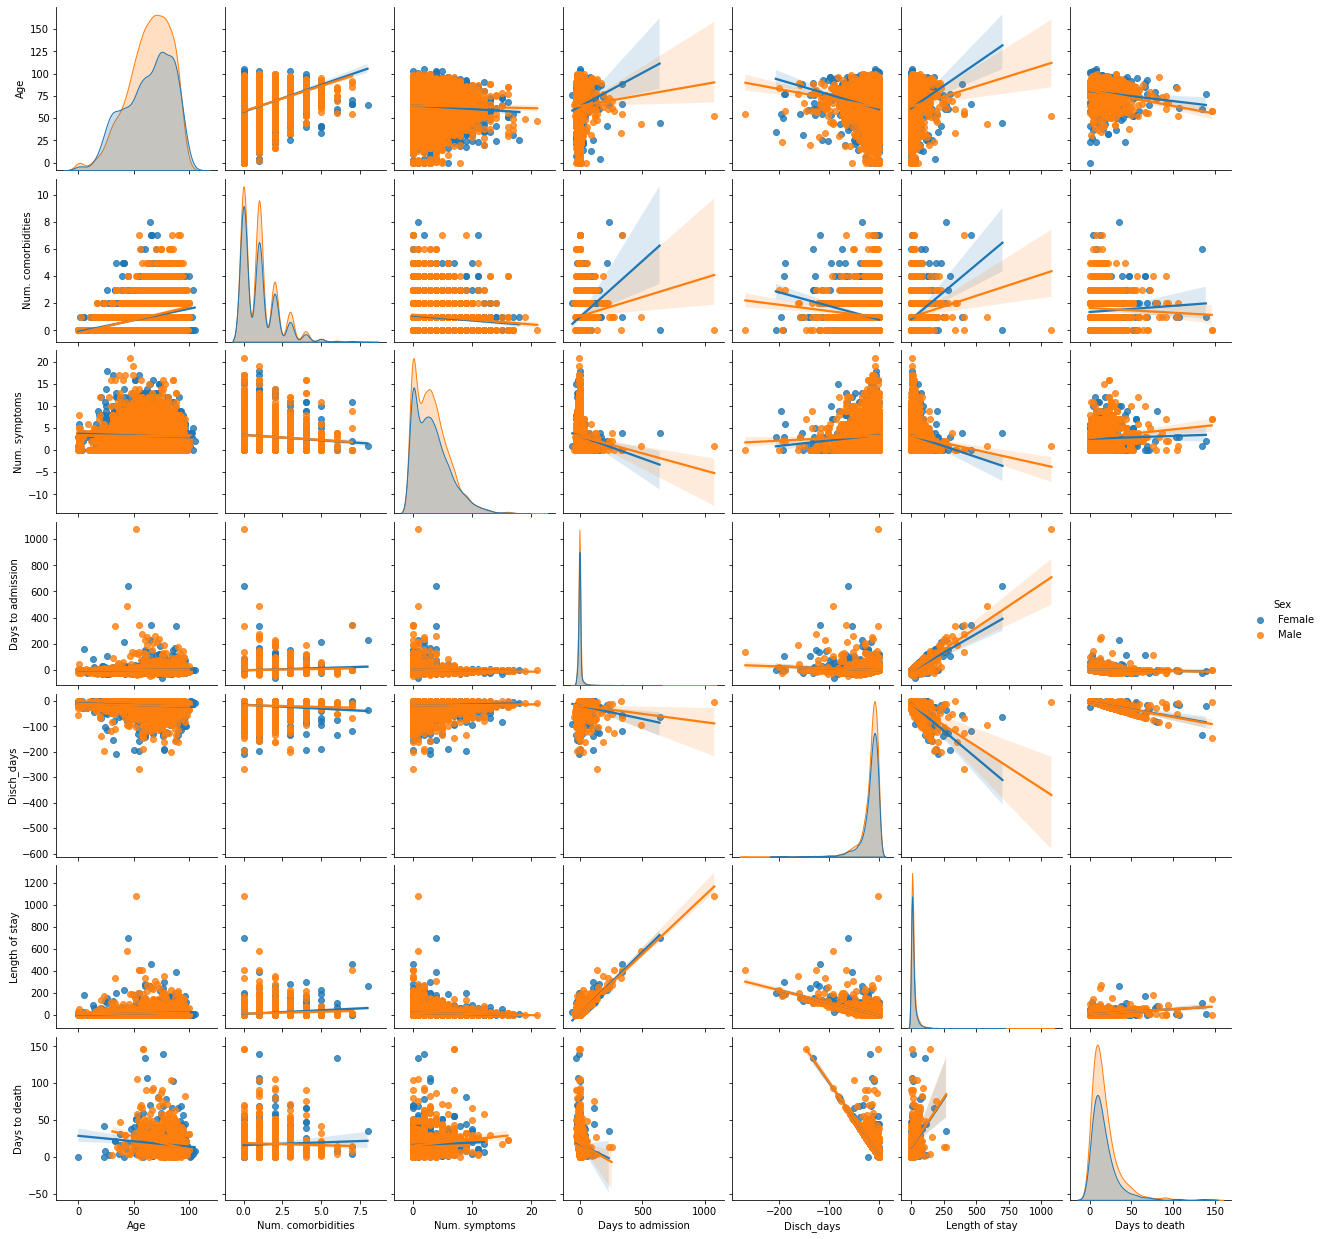

In [4]:
sns.pairplot(df.iloc[:, np.r_[1, 3, 55:57, 58:61, 63]], hue="Sex", kind='reg');

/home/shigoto/.local/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/shigoto/.local/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/shigoto/.local/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/shigoto/.local/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/shigoto/.local/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/shigoto/.local/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance;

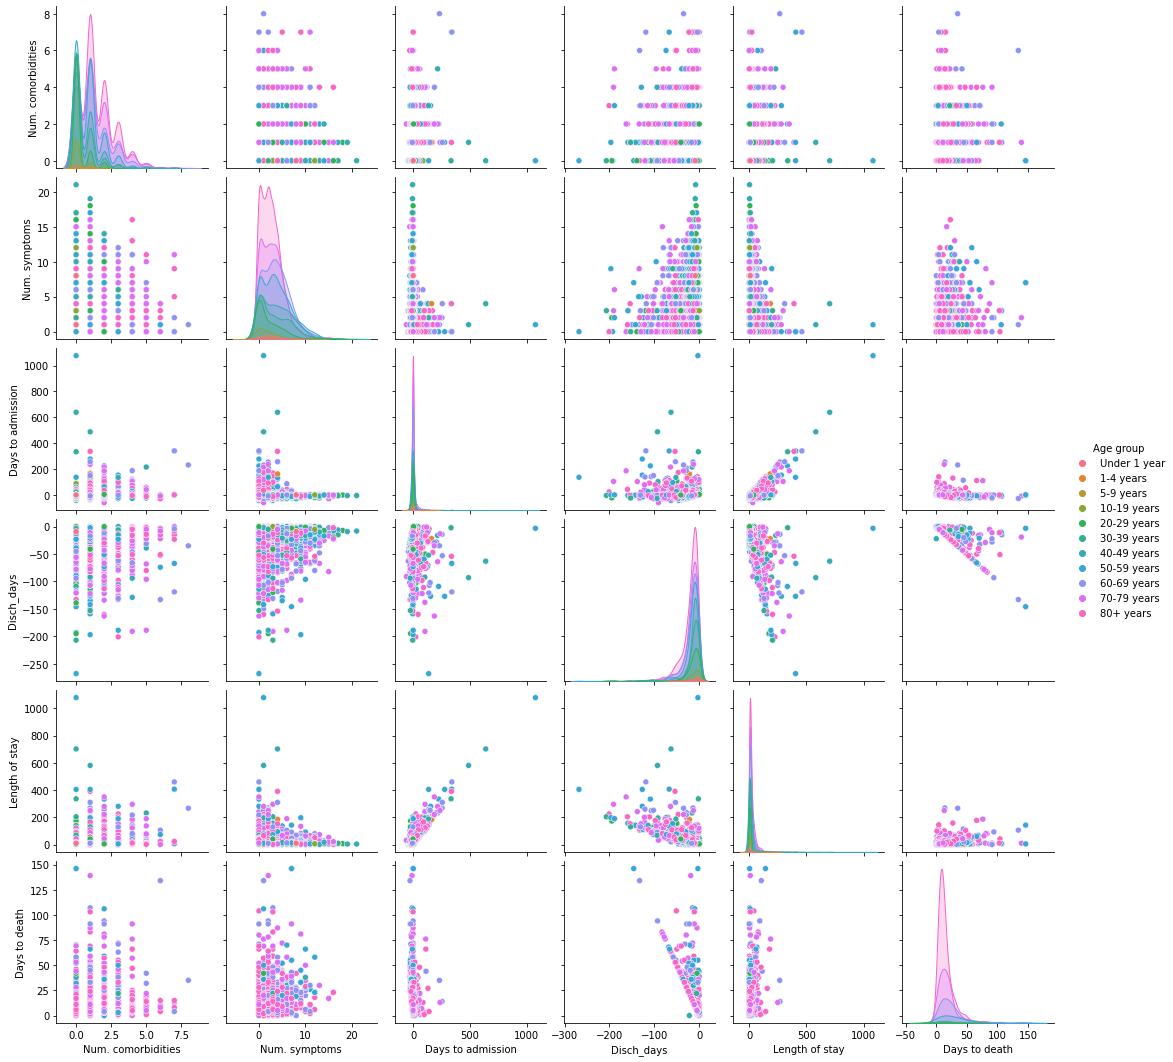

In [5]:
sns.pairplot(df.iloc[:, np.r_[55:61, 63]], hue="Age group");

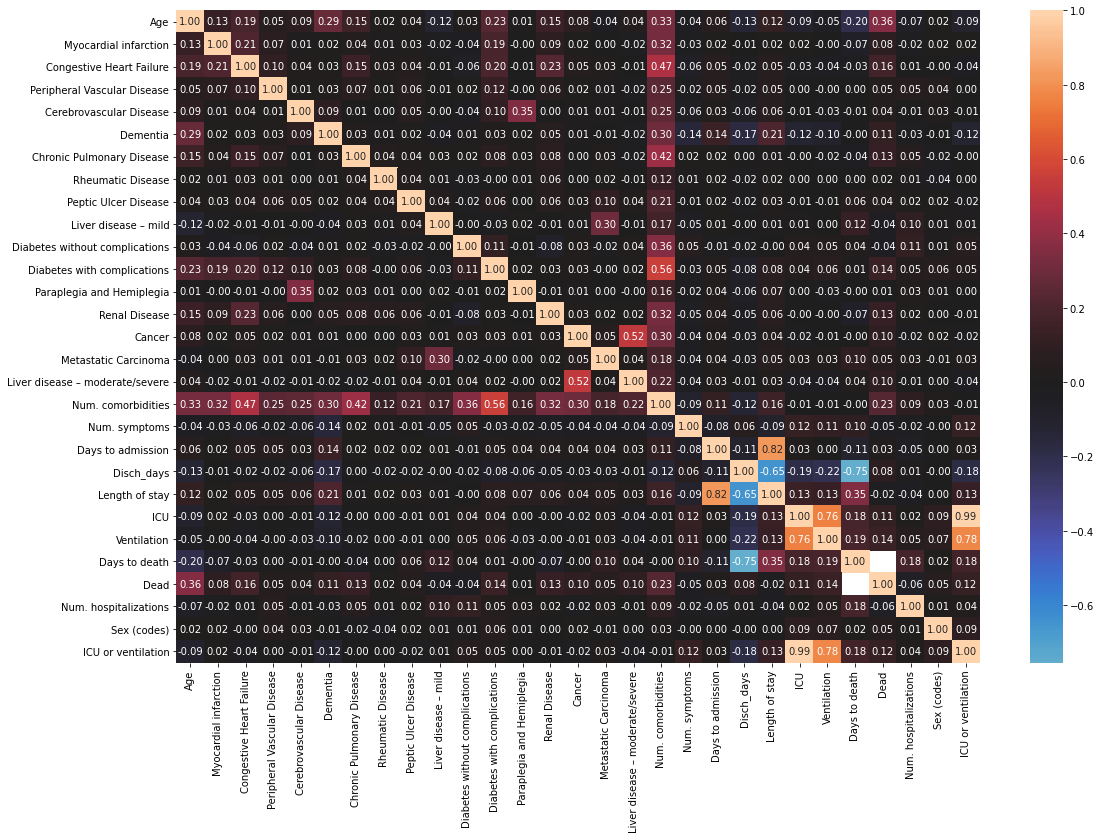

In [6]:
plt.figure(figsize=(18, 12))
sns.heatmap(df.corr(), annot=True, center=0, fmt=".2f")
plt.gcf().get_size_inches();

**Comments:** 
- There is no clear linear correlation between pair of variables, except for days to admission/discharge and lenghtof stay which are clearly related.
- There is some difference between sex, mostly in the number of cases, distribution of age, and the dispersion (higher in females).
- Differences between age groups is clear for elder patient (50+ years).
- There is high correlation between days to admission/length of stay, days to death/days to discharge, and ventilation/ICU.

## 2. Prognosis of complications

Here we define complications as either ICU or ventilation flags. We combine both varibles since those variables are highly correlated

**Data train/test split**

In [7]:
categorical_columns = ['Sex (codes)',
#                         # Comorbidities
#                         'Myocardial infarction', 'Congestive Heart Failure',
#                         'Peripheral Vascular Disease', 'Cerebrovascular Disease', 'Dementia',
#                         'Chronic Pulmonary Disease', 'Rheumatic Disease',
#                         'Peptic Ulcer Disease', 'Liver disease – mild',
#                         'Diabetes without complications', 'Diabetes with complications',
#                         'Paraplegia and Hemiplegia', 'Renal Disease', 'Cancer',
#                         'Metastatic Carcinoma', 'Liver disease – moderate/severe',
#                         # Symptoms
#                         'Abn lung asc', 'Altered mental state', 'Anorexia', 'Arthralgia',
#                         'Chest pain', 'Feverish chills', 'Conjunctivital injecti',
#                         'Conjunctivitis', 'Cough', 'Decreased appetite', 'Diarrhea',
#                         'Dizziness', 'Encephalitis', 'Fever', 'Headache', 'Hypotension',
#                         'Irritability cnfsn', 'Loss of taste smell', 'Malaise', 'Myalgia',
#                         'Nasal congestion', 'Nausea', 'Nose bleed', 'Pain',
#                         'Pharyngeal exudate', 'Prostration', 'Rhinorrhea', 'Seizures',
#                         'Difficulty breathing', 'Sneezing', 'Sore throat', 'Tachypnea',
#                         'Vomiting',
                      ]
numerical_columns = ['Age',
                     'Num. comorbidities', 
                     'Num. symptoms',
                     'Days to admission'
                    ]
input_columns = np.concatenate([categorical_columns, numerical_columns])
output_colum = 'ICU or ventilation' #'Died', 'Length of stay', 'Days to death'
X = df.dropna(subset=['Sex'])[input_columns]
y = df.dropna(subset=['Sex'])[output_colum]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=92736)
print(f'Compliaction rate in train set (n={y_train.size:d}): {(y_train.sum()/y_train.size):.4f}')
print(f'Complication rate in test set (n={y_test.size:d}): {(y_test.sum()/y_test.size):.4f}')

Compliaction rate in train set (n=4701): 0.1883
Complication rate in test set (n=1176): 0.1769


**Model and fit**

In [8]:
method = XGBClassifier(objective='binary:logistic', 
                                   booster='gbtree',
                                   use_label_encoder=False)
params = {'n_estimators': sp.stats.randint(100, 500),
          'learning_rate': sp.stats.uniform(0.01, 0.1),
          'max_depth': [3, 5, 7, 9, 11, 13]}
clf_xgb_cv = RandomizedSearchCV(method, 
                             param_distributions=params, 
                             cv=6,
                             n_iter = 20,
                             scoring = 'roc_auc',
                             verbose=1) #use 1 to turn off verbose
clf_xgb_cv.fit(X_train, y_train, eval_metric='logloss')
clf_xgb = clf_xgb_cv.best_estimator_

Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.2min finished


**Plots**

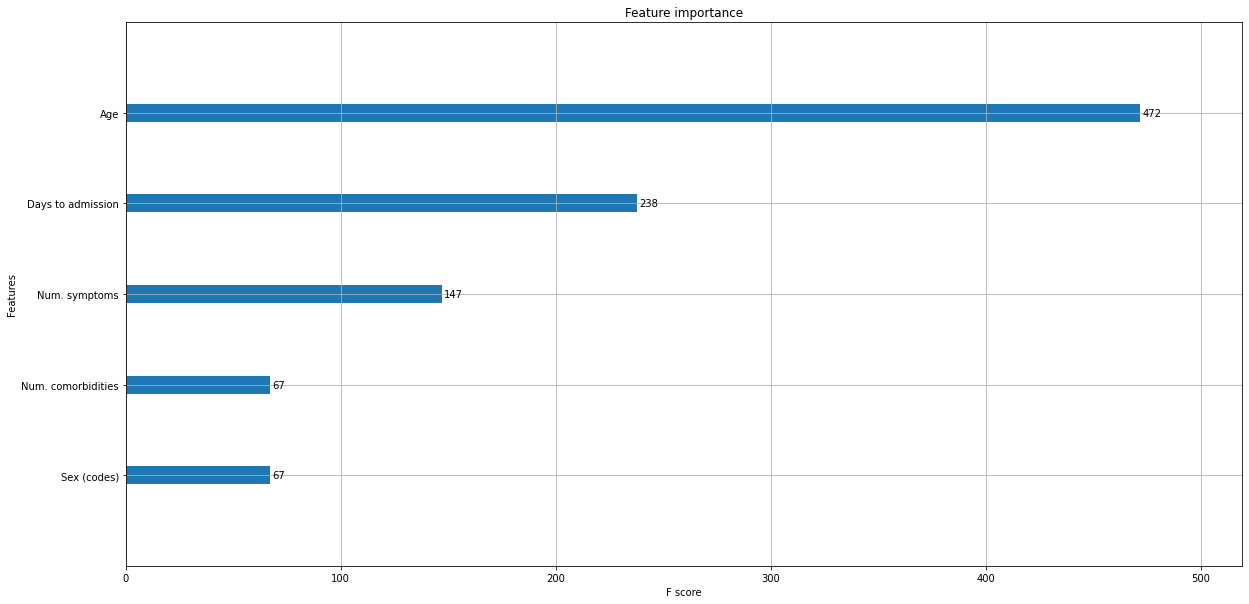

In [9]:
plot_importance(clf_xgb)
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()

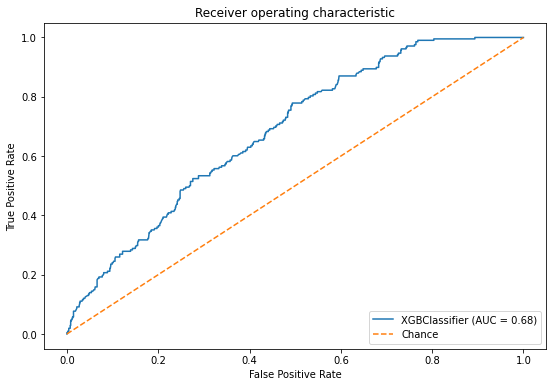

In [10]:
plot_roc_curve(clf_xgb, X_test, y_test)
plt.plot([0, 1], [0, 1], linestyle='--', label='Chance')
plt.legend(loc="lower right")
plt.gcf().set_size_inches(9, 6)
plt.title("Receiver operating characteristic");

**Conclusion:** the performace of the classifier is poor. We tried logistic linear classification and a different inout features, but the performance is not better than the one presented. 

It is possible that the decision of admission to ICU depends on the availability at the hospital, judgement of the nurses/doctors, or clinical/laboratory values (not in the data set).

## 3. Prognosis of death

### 3.1 Logistic regression (with cross validation)

Here we use ligistic regression to predict dead. In the feature selection process we found that comorbidities, symptoms, \age group

**Data train/test split**

In [11]:
categorical_columns = ['Sex',
#                         # Comorbidities
#                         'Myocardial infarction', 'Congestive Heart Failure',
#                         'Peripheral Vascular Disease', 'Cerebrovascular Disease', 'Dementia',
#                         'Chronic Pulmonary Disease', 'Rheumatic Disease',
#                         'Peptic Ulcer Disease', 'Liver disease – mild',
#                         'Diabetes without complications', 'Diabetes with complications',
#                         'Paraplegia and Hemiplegia', 'Renal Disease', 'Cancer',
#                         'Metastatic Carcinoma', 'Liver disease – moderate/severe',
#                         # Symptoms
#                         'Abn lung asc', 'Altered mental state', 'Anorexia', 'Arthralgia',
#                         'Chest pain', 'Feverish chills', 'Conjunctivital injecti',
#                         'Conjunctivitis', 'Cough', 'Decreased appetite', 'Diarrhea',
#                         'Dizziness', 'Encephalitis', 'Fever', 'Headache', 'Hypotension',
#                         'Irritability cnfsn', 'Loss of taste smell', 'Malaise', 'Myalgia',
#                         'Nasal congestion', 'Nausea', 'Nose bleed', 'Pain',
#                         'Pharyngeal exudate', 'Prostration', 'Rhinorrhea', 'Seizures',
#                         'Difficulty breathing', 'Sneezing', 'Sore throat', 'Tachypnea',
#                         'Vomiting',
#                         'Age group',
#                         'ICU', 'Ventilation',
                        'ICU or ventilation'
                      ]
numerical_columns = ['Age',
#                      'Num. hospitalization'
                     'Num. comorbidities', 
#                      'Num. symptoms'
                    ]
input_columns = np.concatenate([categorical_columns, numerical_columns])
output_colum = 'Dead' # 'Length of stay', 'Days to death'
X = df.dropna(subset=input_columns)[input_columns]
y = df.dropna(subset=input_columns)[output_colum]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=92736)
print(f'Death rate in train set (n={y_train.size:d}): {(y_train.sum()/y_train.size):.4f}')
print(f'Death rate in test set (n={y_test.size:d}): {(y_test.sum()/y_test.size):.4f}')

Death rate in train set (n=4701): 0.2027
Death rate in test set (n=1176): 0.1947


**Model and fit**

In [12]:
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='if_binary', sparse=False), categorical_columns),
    (StandardScaler(), numerical_columns),
    remainder='passthrough'
)
method = LogisticRegressionCV(max_iter=1000, cv=6, verbose=1)
clf_log = make_pipeline(
    preprocessor,
    method)
_ = clf_log.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s finished


**Plots**

,Coefficient values,Coefficient importance
Sex_Male,0.277516,0.137987
ICU or ventilation_True,1.492360,0.583390
Age,1.547397,1.547397
Num. comorbidities,0.336118,0.336118


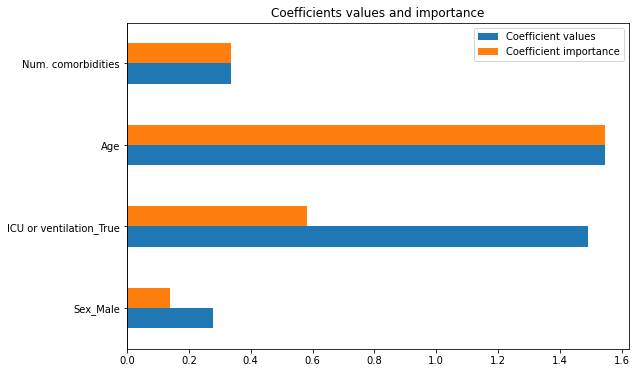

In [13]:
coef = clf_log.named_steps['logisticregressioncv'].coef_[0]
std = clf_log.named_steps['columntransformer'].transform(X_train).std(axis=0)
categorical_columns_transformed = (clf_log.named_steps['columntransformer']
                                          .named_transformers_['onehotencoder']
                                          .get_feature_names(input_features=categorical_columns))
clf_log_coef = pd.DataFrame(np.column_stack((coef, coef*std)),
                            columns=['Coefficient values', 'Coefficient importance'],
                            index=np.concatenate([categorical_columns_transformed,
                                                  numerical_columns]))
display(clf_log_coef)
clf_log_coef.plot(kind='barh', title="")
plt.axvline(x=0, c='k')
plt.gcf().set_size_inches(9, 6)
plt.title('Coefficients values and importance');

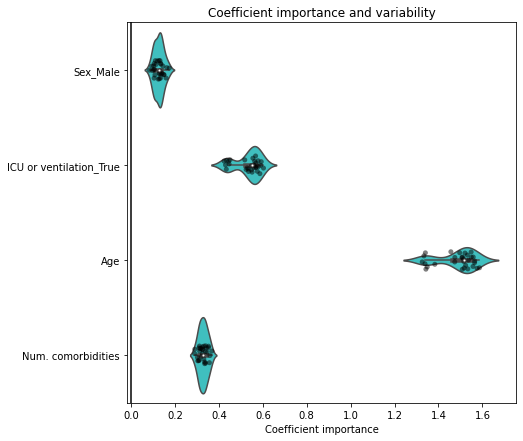

In [14]:
clf_log_cv = cross_validate(
    clf_log, X, y, cv=RepeatedKFold(n_splits=6, n_repeats=5),
    return_estimator=True, n_jobs=-1
)
coefs = pd.DataFrame(
    [est.named_steps['logisticregressioncv'].coef_[0] * std
     for est in clf_log_cv['estimator']],
    columns=np.concatenate([categorical_columns_transformed,
                                                  numerical_columns])
)
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient='h', color='k', alpha=0.5)
sns.violinplot(data=coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='k')
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and variability')
plt.subplots_adjust(left=.3)

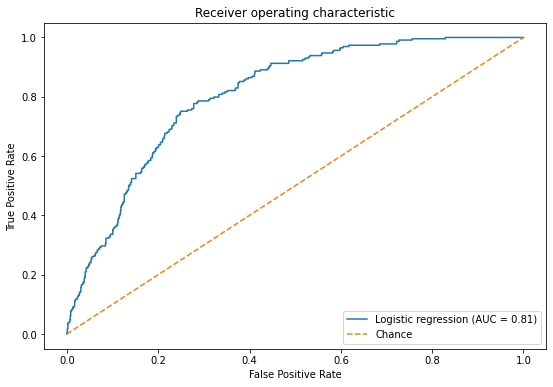

In [15]:
plot_roc_curve(clf_log, X_test, y_test, name='Logistic regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Chance')
plt.legend(loc="lower right")
plt.gcf().set_size_inches(9, 6)
plt.title("Receiver operating characteristic");

**Conclusion:** the performance of the classifier is good. Let's see if a regularized classifier improves the performance.

### 3.2 Ridge classification (with cross validation)

**Data train/test split**

In [16]:
categorical_columns = ['Sex',
#                         # Comorbidities
#                         'Myocardial infarction', 'Congestive Heart Failure',
#                         'Peripheral Vascular Disease', 'Cerebrovascular Disease', 'Dementia',
#                         'Chronic Pulmonary Disease', 'Rheumatic Disease',
#                         'Peptic Ulcer Disease', 'Liver disease – mild',
#                         'Diabetes without complications', 'Diabetes with complications',
#                         'Paraplegia and Hemiplegia', 'Renal Disease', 'Cancer',
#                         'Metastatic Carcinoma', 'Liver disease – moderate/severe',
#                         # Symptoms
#                         'Abn lung asc', 'Altered mental state', 'Anorexia', 'Arthralgia',
#                         'Chest pain', 'Feverish chills', 'Conjunctivital injecti',
#                         'Conjunctivitis', 'Cough', 'Decreased appetite', 'Diarrhea',
#                         'Dizziness', 'Encephalitis', 'Fever', 'Headache', 'Hypotension',
#                         'Irritability cnfsn', 'Loss of taste smell', 'Malaise', 'Myalgia',
#                         'Nasal congestion', 'Nausea', 'Nose bleed', 'Pain',
#                         'Pharyngeal exudate', 'Prostration', 'Rhinorrhea', 'Seizures',
#                         'Difficulty breathing', 'Sneezing', 'Sore throat', 'Tachypnea',
#                         'Vomiting',
#                         'Age group',
                        'ICU', 'Ventilation',
#                         'ICU or ventilation'
                      ]
numerical_columns = ['Age',
#                      'Num. hospitalization'
                     'Num. comorbidities', 
#                      'Num. symptoms'
                    ]
input_columns = np.concatenate([categorical_columns, numerical_columns])
output_colum = 'Dead' # 'Length of stay', 'Days to death'
X = df.dropna(subset=input_columns)[input_columns]
y = df.dropna(subset=input_columns)[output_colum]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=92736)
print(f'Death rate in train set (n={y_train.size:d}): {(y_train.sum()/y_train.size):.4f}')
print(f'Death rate in test set (n={y_test.size:d}): {(y_test.sum()/y_test.size):.4f}')

Death rate in train set (n=4701): 0.2027
Death rate in test set (n=1176): 0.1947


**Model and fit**

In [17]:
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='if_binary', sparse=False), categorical_columns),
    (StandardScaler(), numerical_columns),
    remainder='passthrough'
)
method = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv=6)
clf_log = make_pipeline(
    preprocessor,
    method)
clf_log.fit(X_train, y_train);

**Plots**

In [18]:
coef = clf_log.named_steps['ridgeclassifiercv'].coef_[0]
std = clf_log.named_steps['columntransformer'].transform(X_train).std(axis=0)
categorical_columns_transformed = (clf_log.named_steps['columntransformer']
                                          .named_transformers_['onehotencoder']
                                          .get_feature_names(input_features=categorical_columns))
clf_log_coef = pd.DataFrame(np.column_stack((coef, coef*std)),
                            columns=['Coefficient values', 'Coefficient importance'],
                            index=np.concatenate([categorical_columns_transformed,
                                                  numerical_columns]))
clf_log_coef

,Coefficient values,Coefficient importance
Sex_Male,0.054525,0.027111
ICU_True,0.106196,0.041131
Ventilation_True,0.322319,0.105131
Age,0.266962,0.266962
Num. comorbidities,0.097225,0.097225


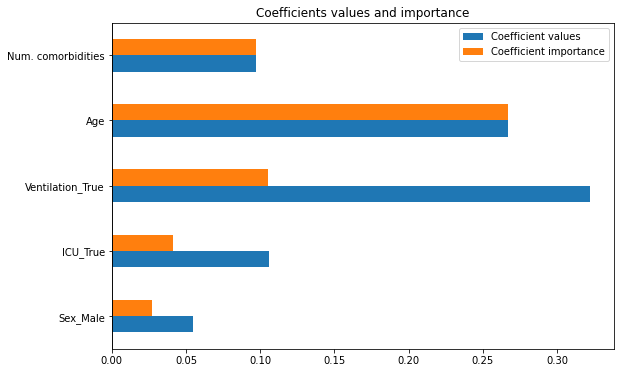

In [19]:
clf_log_coef.plot(kind='barh', title="")
plt.axvline(x=0, c='k')
plt.gcf().set_size_inches(9, 6)
plt.title('Coefficients values and importance');

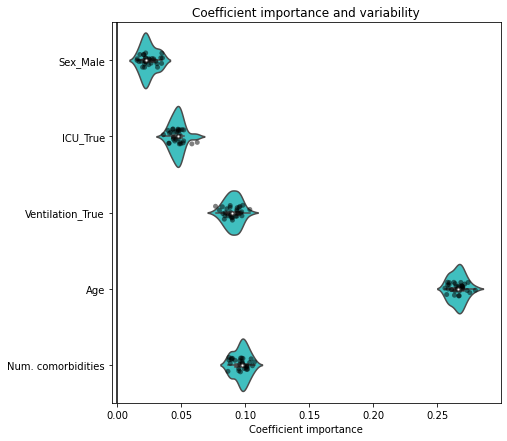

In [20]:
clf_log_cv = cross_validate(
    clf_log, X, y, cv=RepeatedKFold(n_splits=6, n_repeats=5),
    return_estimator=True, n_jobs=-1
)
coefs = pd.DataFrame(
    [est.named_steps['ridgeclassifiercv'].coef_[0] * std
     for est in clf_log_cv['estimator']],
    columns=np.concatenate([categorical_columns_transformed,
                                                  numerical_columns])
)
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient='h', color='k', alpha=0.5)
sns.violinplot(data=coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='k')
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and variability')
plt.subplots_adjust(left=.3)

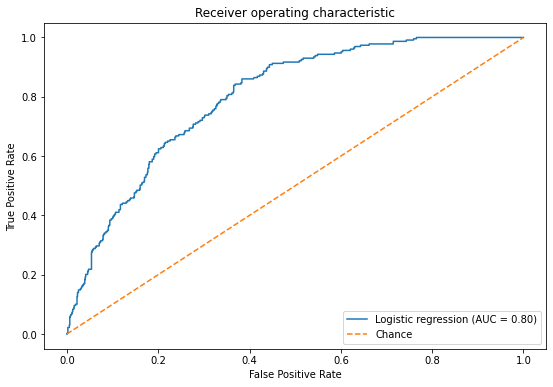

In [21]:
plot_roc_curve(clf_log, X_test, y_test, name='Logistic regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Chance')
plt.legend(loc="lower right")
plt.gcf().set_size_inches(9, 6)
plt.title("Receiver operating characteristic");

Regularization takes into account the high correlation between ICU and Ventilation, but the classifier does not improve compared to without regularization.

### 3.3 Gradient boosting decision tree classifier

Finally lets try a boosted decision tree classifier

**Data train/test split**

In [22]:
feature_idx = np.r_[1, 66, 55, 56, 61, 62] # 4:20 left out (same AUC)
feature_names = df.columns[feature_idx]
X = df.dropna(subset=['Sex'])[feature_names]
y = df.dropna(subset=['Sex'])['Dead']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=92736)
print(f'Death rate in train set (n={y_train.size:d}): {(y_train.sum()/y_train.size):.4f}')
print(f'Death rate in test set (n={y_test.size:d}): {(y_test.sum()/y_test.size):.4f}')

Death rate in train set (n=4701): 0.2027
Death rate in test set (n=1176): 0.1947


**Model and fit**

In [23]:
xgb_clf = XGBClassifier(objective='binary:logistic', 
                                   booster='gbtree',
                                   use_label_encoder=False)
params = {'n_estimators': sp.stats.randint(100, 500),
          'learning_rate': sp.stats.uniform(0.01, 0.1),
          'max_depth': [3, 5, 7, 9, 11, 13]}
cv_xgb_clf = RandomizedSearchCV(xgb_clf, 
                             param_distributions=params, 
                             cv=6,
                             n_iter = 20,
                             scoring = 'roc_auc',
                             verbose=1) #use 1 to turn off verbose
cv_xgb_clf.fit(X_train, y_train, eval_metric='logloss')
xgb_clf_best = cv_xgb_clf.best_estimator_

Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   50.6s finished


**Plots**

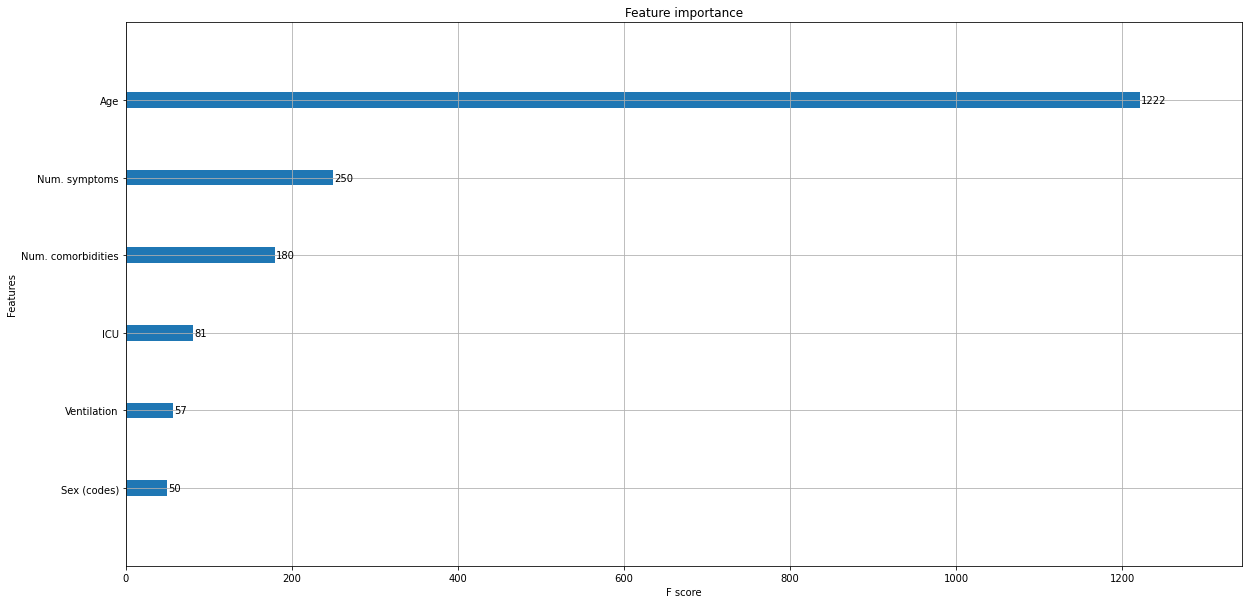

In [24]:
plot_importance(xgb_clf_best)
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()

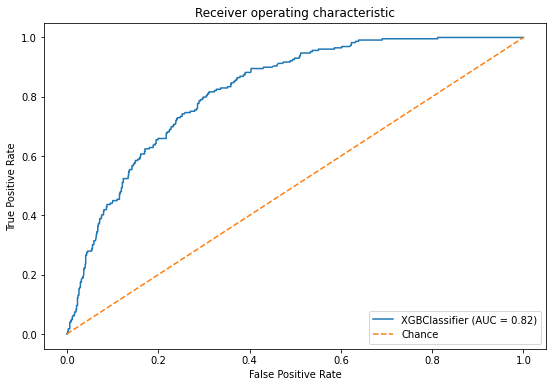

In [25]:
plot_roc_curve(xgb_clf_best, X_test, y_test)
plt.plot([0, 1], [0, 1], linestyle='--', label='Chance')
plt.legend(loc="lower right")
plt.gcf().set_size_inches(9, 6)
plt.title("Receiver operating characteristic");

## 4. Prognosis of days to death

**Data train/test split**

In [26]:
categorical_columns = ['Sex',
#                         # Co|tatic Carcinoma', 'Liver disease – moderate/severe',
#                         # Symptoms
#                         'Abn lung asc', 'Altered mental state', 'Anorexia', 'Arthralgia',
#                         'Chest pain', 'Feverish chills', 'Conjunctivital injecti',
#                         'Conjunctivitis', 'Cough', 'Decreased appetite', 'Diarrhea',
#                         'Dizziness', 'Encephalitis', 'Fever', 'Headache', 'Hypotension',
#                         'Irritability cnfsn', 'Loss of taste smell', 'Malaise', 'Myalgia',
#                         'Nasal congestion', 'Nausea', 'Nose bleed', 'Pain',
#                         'Pharyngeal exudate', 'Prostration', 'Rhinorrhea', 'Seizures',
#                         'Difficulty breathing', 'Sneezing', 'Sore throat', 'Tachypnea',
#                         'Vomiting',
#                         'Age group',
#                         'ICU', 'Ventilation',
                        'ICU or ventilation'
                      ]
numerical_columns = ['Age',
#                      'Num. hospitalization'
                     'Num. comorbidities', 
                     'Num. symptoms',
                     'Days to admission'
                    ]
input_columns = np.concatenate([categorical_columns, numerical_columns])
output_colum = 'Days to death' # 'Length of stay', 'Days to death'
X = df.loc[df['Dead'],:].dropna(subset=input_columns)[input_columns]
y = df.loc[df['Dead'],:].dropna(subset=input_columns)[output_colum]
y = quantile_transform(y.to_frame(),
                             n_quantiles=900,
                             output_distribution='normal',
                             copy=True).squeeze()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9160)
print(f'Mean (std) days to death in train set (n={y_train.size:d}): {y_train.mean():.4f} ({y_train.std():.4f})')
print(f'Mean (std) days to death in test set (n={y_test.size:d}): {y_test.mean():.4f} ({y_test.std():.4f})')

Mean (std) days to death in train set (n=945): -0.0458 (1.1656)
Mean (std) days to death in test set (n=237): -0.0390 (1.2478)


**Model and fit**

In [27]:
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='if_binary', sparse=False), categorical_columns),
    (StandardScaler(), numerical_columns),
    remainder='passthrough'
)
method = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])
reg_rid = make_pipeline(
    preprocessor,
    method)
_ = reg_rid.fit(X_train, y_train)

**Plots**

,Coefficient values,Coefficient importance
Sex_Male,-0.015111,-0.007383
ICU or ventilation_True,0.362625,0.161941
Age,-0.064989,-0.064989
Num. comorbidities,0.021884,0.021884
Num. symptoms,0.118125,0.118125
Days to admission,-0.118260,-0.118260


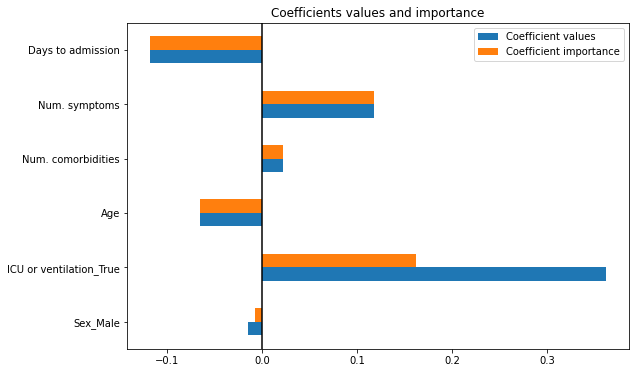

In [28]:
coef = reg_rid.named_steps['ridgecv'].coef_
std = reg_rid.named_steps['columntransformer'].transform(X_train).std(axis=0)
categorical_columns_transformed = (reg_rid.named_steps['columntransformer']
                                          .named_transformers_['onehotencoder']
                                          .get_feature_names(input_features=categorical_columns))
reg_rid_coef = pd.DataFrame(np.column_stack((coef, coef*std)),
                            columns=['Coefficient values', 'Coefficient importance'],
                            index=np.concatenate([categorical_columns_transformed,
                                                  numerical_columns]))
display(reg_rid_coef)
reg_rid_coef.plot(kind='barh', title="")
plt.axvline(x=0, c='k')
plt.gcf().set_size_inches(9, 6)
plt.title('Coefficients values and importance');

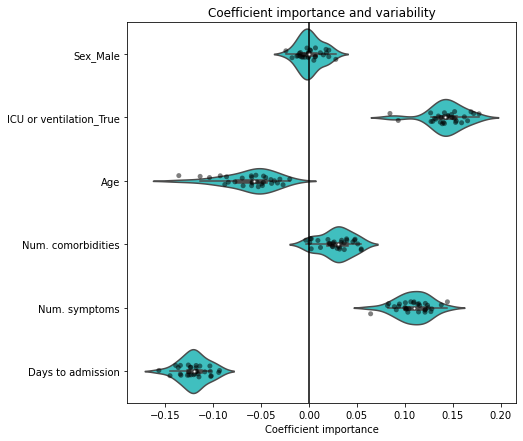

In [29]:
reg_rid_cv = cross_validate(
    reg_rid, X, y, cv=RepeatedKFold(n_splits=6, n_repeats=5),
    return_estimator=True, n_jobs=-1
)
coefs = pd.DataFrame(
    [est.named_steps['ridgecv'].coef_ * std
     for est in reg_rid_cv['estimator']],
    columns=np.concatenate([categorical_columns_transformed,
                                                  numerical_columns])
)
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient='h', color='k', alpha=0.5)
sns.violinplot(data=coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='k')
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and variability')
plt.subplots_adjust(left=.3)

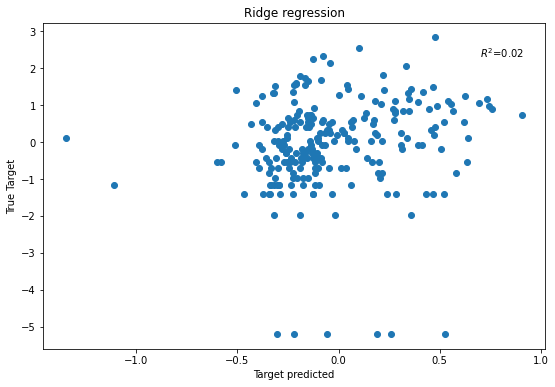

In [30]:
y_pred = reg_rid.predict(X_test)
plt.scatter(y_pred, y_test)
# plt.plot([0, 2000], [0, 2000], '--k')
plt.xlabel('Target predicted')
plt.ylabel('True Target')
plt.title('Ridge regression')
plt.text(0.7, 2.3, r'$R^2$=%.2f' % (r2_score(y_test, y_pred)))
plt.gcf().set_size_inches(9, 6)

**Conclusion:** preditor is useless.

In [31]:
pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : d9fff2792bf16178d4e450fe7384244e50635733
python           : 3.8.10.final.0
python-bits      : 64
OS               : Linux
OS-release       : 5.14.0-051400-generic
Version          : #202108292331 SMP Sun Aug 29 23:33:39 UTC 2021
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : None
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 1.1.0
numpy            : 1.19.1
pytz             : 2019.3
dateutil         : 2.7.3
pip              : 20.0.2
setuptools       : 45.2.0
Cython           : None
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : 4.5.0
html5lib         : 1.0.1
pymysql          : None
psycopg2         : None
jinja2           : 2.11.2
IPython          : 7.17.0
pandas_datareader: None
bs4              : 4.8.2
bottleneck       : None
fss